## Lung Classification Assignment

#### Completed homework example

This is the completed notebook that can be used to grade the students submission.

This course will build upon the knowledge gained in the first lesson and will utilize a much larger dataset.

In this course you will build a deep learning model that identifies whether an x-ray of the lungs contains an opacity. The dataset is from a Kaggle challenge.

The dataset comes from the RSNA Pneumonia Detection Challenge (Kaggel API)
        ,
        "The [Radiological Society of North America](http://www.rsna.org/) Pneumonia Detection Challenge: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge",


<img src="images/lesson2_datasetImage.png">



In [3]:
# Include the mdai module, output current mdai version
!pip install -q --upgrade mdai
import mdai
mdai.__version__

'0.7.8'

In [4]:
# Add mdai client
mdai_client = mdai.Client(domain='public.md.ai', access_token="b7f61f52767e27a00f83ab3686ede0e5")

Successfully authenticated to public.md.ai.


In [5]:
p = mdai_client.project('LxR6zdR2', path='./lung-opacity-data')

Using path './lung-opacity-data' for data.
Preparing annotations export for project LxR6zdR2...                                                
Using cached annotations data for project LxR6zdR2.
Preparing images export for project LxR6zdR2...                                                     
Using cached images data for project LxR6zdR2.


In [6]:
p.show_label_groups()

Label Group, Id: G_R28gN5, Name: Default group
	Labels:
	Id: L_ylR0L8, Name: No Lung Opacity
	Id: L_DlqEAl, Name: Lung Opacity



In [7]:
# this maps label ids to class ids as a dict obj
labels_dict = {'L_ylR0L8':0, # No Lung Opacity 
               'L_DlqEAl':1, # Lung Opacity  
              }

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_ylR0L8': 0, 'L_DlqEAl': 1}


In [8]:
# show dataset ID and label mappings
p.show_datasets() 

Datasets:
Id: D_ao3XWQ, Name: stage 1 train



### Display label classes

In [9]:
dataset = p.get_dataset_by_id('D_ao3XWQ')
dataset.prepare()
dataset.show_classes()

Label id: L_ylR0L8, Class id: 0, Class text: No Lung Opacity
Label id: L_DlqEAl, Class id: 1, Class text: Lung Opacity


In [10]:
anns = dataset.get_annotations()

while 0:
    # create training dataset 
    train_dataset = p.get_dataset_by_name('TRAIN')
    train_dataset.prepare() 
    train_image_ids = train_dataset.get_image_ids()
    print(len(train_image_ids))


    # create the validation dataset 
    val_dataset = p.get_dataset_by_name('VAL')
    val_dataset.prepare()
    val_image_ids = val_dataset.get_image_ids()
    print(len(val_image_ids))

In [11]:
train_dataset, val_dataset = mdai.common_utils.train_test_split(dataset, validation_split = 0.98)
val_dataset, test_dataset = mdai.common_utils.train_test_split(val_dataset, validation_split = 0.995)
test_dataset, test_dataset2 = mdai.common_utils.train_test_split(test_dataset, validation_split = 0.90)

Num of instances for training set: 513, validation set: 25171
Num of instances for training set: 125, validation set: 25046
Num of instances for training set: 2504, validation set: 22542


In [12]:
anns = dataset.get_annotations(labels_dict.keys(), verbose=True)

Dataset contains 28989 annotations, filtered by label ids dict_keys(['L_ylR0L8', 'L_DlqEAl']).


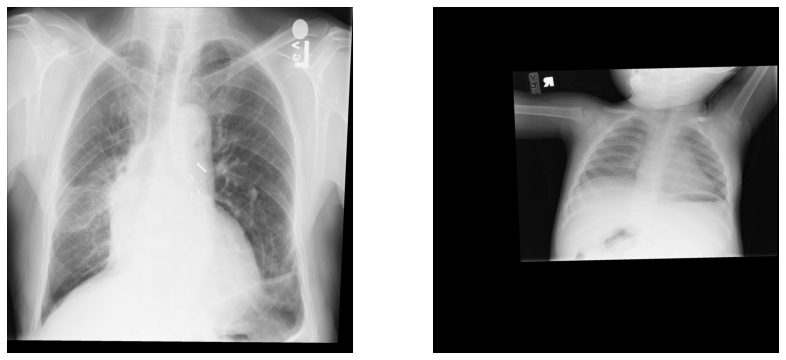

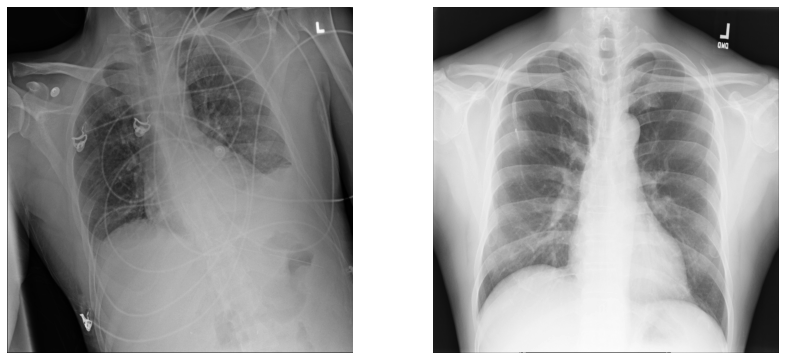

In [13]:
train_image_ids = train_dataset.get_image_ids()
val_image_ids = val_dataset.get_image_ids()

# visualize a few train images 
mdai.visualize.display_images(train_image_ids[:2], cols=2)
mdai.visualize.display_images(val_image_ids[:2], cols=2)

In [14]:
import numpy as np
# get image pixel data
pixel_array = mdai.visualize.load_dicom_image(train_image_ids[0], to_RGB=False, rescale=True)
print(np.shape(pixel_array))

(1024, 1024)


In [25]:
# Import keras module
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend

In [ ]:
# Define model parameters 
img_width = 128
img_height = 128
epochs = 20

params = {
    'dim': (img_width, img_height),
    'batch_size': 8,
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': True,
}

# Begin Defining Model

Here we build up a very basic CNN architecture (similar in nature to the VGG class of architectures).

Here is where you can feel free to experiment with different architectures and tune the hyperparameters of the network. You should observe differences in training performance, as well as the amount of time required to fully train the network. 

Try changing the number of kernels in the network from 32 down to 16.

For example:

```python
conv1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
```

Or changing the size of the filter kernels from 3x3 to 5x5

```python
conv1 = Conv2D(32, (5,5), activation = 'relu', padding='same')(inputs)
```

Or the activation function for the output:

```python
conv1 = Conv2D(32, (3,3), activation = 'tanh', padding='same')(inputs)
```

How do these parameters affect performance and training time?

# Begin Defining Model

In [27]:
model_test1 = True

# CNN example
if model_test1 is True:
    # Create a basic CNN architecture

    inputs = Input((img_width, img_height, 3))

    # Block1
    conv1 = Conv2D(32, (3,3), activation = 'relu', padding='same')(inputs)
    conv2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(conv1)
    max1 = MaxPooling2D((4,4), strides = (4,4))(conv2)

    # Block2
    conv3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(max1)
    conv4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv3)
    max2 = MaxPooling2D((4,4), strides = (4,4))(conv4)

    fcn = Flatten()(max2)
    fcn = Dense(512,activation='relu')(fcn) # was 1028
    fcn = Dropout(0.5)(fcn)
    fcn = Dense(256,activation='relu')(fcn) # was 512
    fcn = Dropout(0.5)(fcn)
    output = Dense(2,activation='softmax')(fcn)

    model = Model(inputs,output)

    model.compile(optimizer=Adam(learning_rate=5.E-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
                  loss='categorical_crossentropy', metrics=['accuracy'])


# End Defining Model

In [35]:
from mdai.utils import keras_utils
#import tensorflow.keras.utils as keras_utils
train_generator = keras_utils.DataGenerator(train_dataset, **params)
val_generator = keras_utils.DataGenerator(val_dataset, **params)

In [36]:
#import tensorflow as tf 
#config = tf.compat.v1.ConfigProto() #update for tf2 compatibility
#config.gpu_options.allow_growth = True

# Train Model

In [37]:
# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=2),
    ModelCheckpoint(filepath='best_model_lesson2.h5', monitor='val_accuracy',
                    save_best_only=True, verbose=2)
]

history = model.fit_generator(
            generator=train_generator,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1,            
            validation_data=val_generator,
            use_multiprocessing=False,
            workers=8)             

/Users/mri3977/PyEnv/marvin3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-08-10 10:53:28.930140: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
64/64 [==============================] - 18s 259ms/step - loss: 16.2547 - accuracy: 0.5234 - val_loss: 5.7100 - val_accuracy: 0.8333

Epoch 00001: val_accuracy improved from -inf to 0.83333, saving model to best_model_lesson2.h5
Epoch 2/20
64/64 [==============================] - 17s 247ms/step - loss: 9.1723 - accuracy: 0.6465 - val_loss: 6.6613 - val_accuracy: 0.8167

Epoch 00002: val_accuracy did not improve from 0.83333
Epoch 3/20
64/64 [==============================] - 16s 247ms/step - loss: 9.2190 - accuracy: 0.6543 - val_loss: 5.3999 - val_accuracy: 0.8250

Epoch 00003: val_accuracy did not improve from 0.83333
Epoch 4/20
64/64 [==============================] - 16s 251ms/step - loss: 7.6734 - accuracy: 0.6504 - val_loss: 4.7079 - val_accuracy: 0.8250

Epoch 00004: val_accuracy did not improve from 0.83333
Epoch 5/20
64/64 [==============================] - 16s 248ms/step - loss: 6.9646 - accuracy: 0.6562 - val_loss: 3.7613 - val_accuracy: 0.8167

Epoch 00005: val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


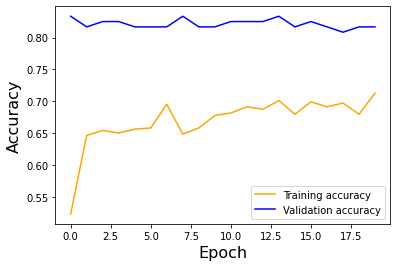

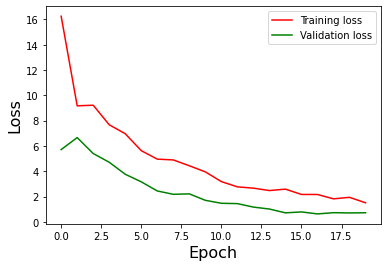

In [38]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize = 16)
plt.show()

plt.figure()
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

# Create the Test dataset

In [39]:
model.load_weights('best_model_lesson2.h5')
test_dataset.prepare()
print(len(test_dataset.image_ids))

25684


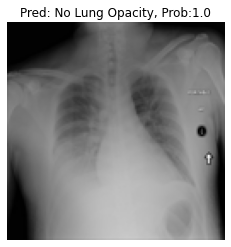

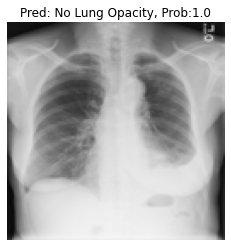

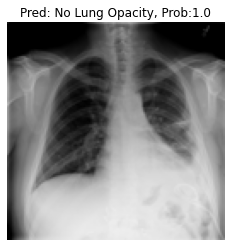

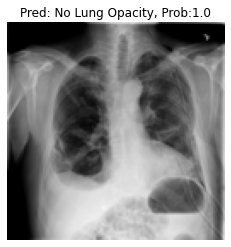

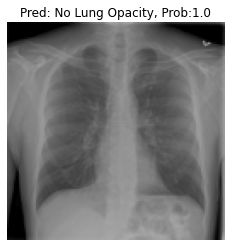

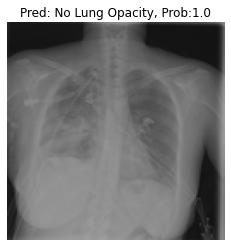

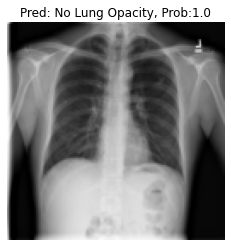

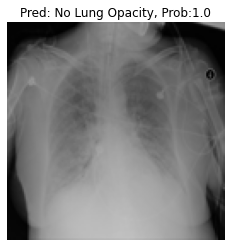

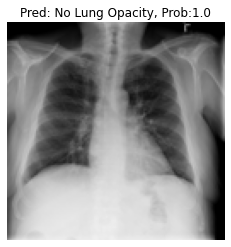

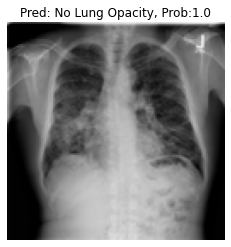

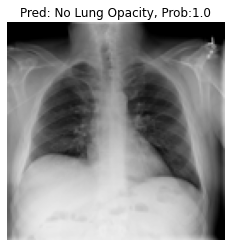

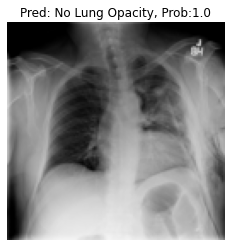

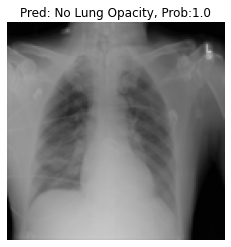

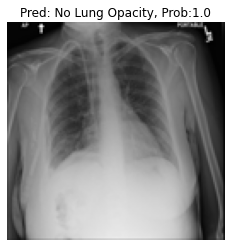

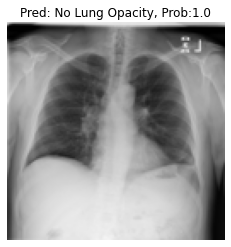

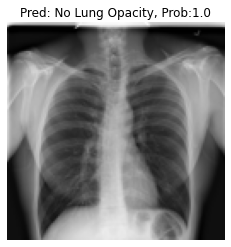

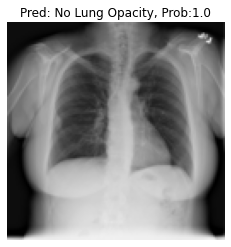

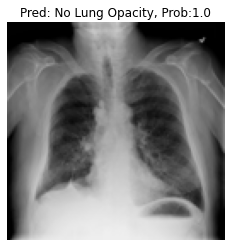

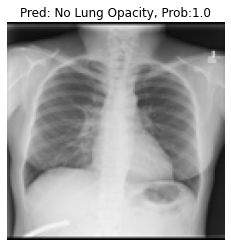

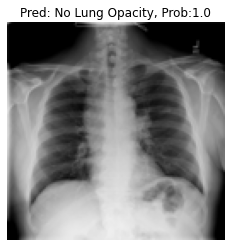

In [40]:
import numpy as np
#from skimage.transform import resize
from PIL import Image 

for image_id in test_dataset.image_ids[80:100]: 
    
    image = mdai.visualize.load_dicom_image(image_id, to_RGB=True)
    image = Image.fromarray(image)
    image = image.resize((img_width, img_height))
    
    x = np.expand_dims(image, axis=0)    
    y_prob = model.predict(x) 
    y_classes = y_prob.argmax(axis=-1)
    
    title = 'Pred: ' + test_dataset.class_id_to_class_text(y_classes[0]) + ', Prob:' + str(round(y_prob[0][y_classes[0]], 3))
    
    plt.figure()
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    
plt.show()

In [41]:
# ------------ Activation Maps

In [42]:
from keras.models import Sequential
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras import backend as K
import h5py
from keras.optimizers import SGD

def global_average_pooling(x):
    return K.mean(x, axis = (2,3))

def global_average_pooling_shape(input_shape):
    return input_shape[0:2]

def VGG_like_convolutions():
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1),input_shape=(128,128,3)))
    model.add(Convolution2D(16, (3, 3), activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(16, (3, 3), activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(32, (3, 3), activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(32, (3, 3), activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu', name='conv3_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation='relu', name='conv4_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    return model

def get_model_vgg_like():
    model = VGG_like_convolutions()
    
    model.add(Lambda(global_average_pooling, 
              output_shape=global_average_pooling_shape))
    model.add(Dense(2, activation = 'softmax', kernel_initializer='uniform'))
    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
    model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])
    return model

def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

model = get_model_vgg_like()

# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=2),
    ModelCheckpoint(filepath='best_model_am2.h5', monitor='val_loss', 
                    save_best_only=True, verbose=2)
]

history = model.fit_generator(
            generator=train_generator,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1, #on a Windows machine you may want to use verbose=0           
            validation_data=val_generator,
            use_multiprocessing=False,
            workers=4) 

AttributeError: module 'tensorflow.compat.v2.__internal__' has no attribute 'register_clear_session_function'

In [ ]:
import cv2

def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

def visualize_class_activation_map(model, img):
    model = model
    original_img = img
    width = 128
    height = 128

    #Get the 512 input weights to the softmax.
    class_weights = model.layers[-1].get_weights()[0]
    final_conv_layer = get_output_layer(model, "conv4_2")
    get_output = K.function([model.layers[0].input], \
        [final_conv_layer.output, 
    model.layers[-1].output])
    [conv_outputs, predictions] = get_output([np.float32(img)])
    
    conv_outputs = conv_outputs[0, :, :, :]
    
    #Create the class activation map.
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, 1]):
            cam += w * conv_outputs[:, :, i]
    #print("predictions", predictions)

    cam = cv2.resize(cam, (height, width))

    return cam



In [ ]:
import numpy as np
from PIL import Image 

for image_id in test_dataset.image_ids[80:100]: 
    
    image = mdai.visualize.load_dicom_image(image_id, to_RGB=True)
    image = Image.fromarray(image)
    image = image.resize((img_width, img_height))
    
    x = np.expand_dims(image, axis=0)    
    y_prob = model.predict(x) 
    y_classes = y_prob.argmax(axis=-1)
    
    title = 'Pred: ' + test_dataset.class_id_to_class_text(y_classes[0]) + ', Prob:' + str(round(y_prob[0][y_classes[0]], 3))
    
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap='jet')
    plt.axis('off')
    
    # Add the activation map overlay
    cam = visualize_class_activation_map(model, x)
    cam = cam - np.min(cam)
    cam[cam<np.max(cam)/2]=0
    masked = np.ma.masked_where(cam == 0, cam)
    plt.imshow(masked,cmap='jet',alpha=0.3)
    plt.axis('off')
    
plt.show()

In [ ]:
# Generate learning curves for this final network

import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize = 16)
plt.show()

plt.figure()
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()